In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


### EDA

In [2]:
# Read dataset
file_path = "E:/Uni/Thesis/Material/Dataset/archive/world_development_data_imputed.csv"
data = pd.read_csv(file_path, sep=',')

# Explore the data
print(data.head(5))
print(data.isna().sum())

     Year           Country   Region           SubRegion  SurfAreaSqKm  \
0  2000.0       Afghanistan     Asia       Southern Asia      652860.0   
1  2000.0             Malta   Europe     Southern Europe         320.0   
2  2000.0           Belgium   Europe      Western Europe       30530.0   
3  2000.0  Marshall Islands  Oceania          Micronesia         180.0   
4  2000.0        Mauritania   Africa  Sub-Saharan Africa     1030700.0   

     PopTotal      PopDens  PopGrowth%           GDP  GDPGrowth%  ...  \
0  19542982.0    29.963329    1.443803  1.801248e+10   -5.206288  ...   
1    390087.0  1219.021875    0.645267  4.323339e+09   19.681791  ...   
2  10251250.0   338.548547    0.242518  2.367925e+11    3.716679  ...   
3     54224.0   301.244444    0.721838  1.153475e+08    1.354079  ...   
4   2695003.0     2.614731    2.799182  1.779521e+09   -3.918026  ...   

       GNIAtlas  Imports%GDP  IndValAdd%GDP  InflConsPric%  LifeExpBirth  \
0  1.778669e+10    41.312634      17.178

In [3]:
data.columns

Index(['Year', 'Country', 'Region', 'SubRegion', 'SurfAreaSqKm', 'PopTotal',
       'PopDens', 'PopGrowth%', 'GDP', 'GDPGrowth%', 'AdolFertRate',
       'AgriValAdd%GDP', 'Exports%GDP', 'FertRate', 'FDINetBoP',
       'GNI/CapAtlas', 'GNIAtlas', 'Imports%GDP', 'IndValAdd%GDP',
       'InflConsPric%', 'LifeExpBirth', 'MerchTrade%GDP', 'MobileSubs/100',
       'MortRateU5', 'NetMigr', 'UrbanPopGrowth%'],
      dtype='object')

In [4]:
# Preprocess data
europe_data = data[data['Region'] == 'Europe']
europe_data = europe_data.drop(columns=['Year', 'SurfAreaSqKm', 'UrbanPopGrowth%', 'PopDens', 'PopTotal'])
europe_data = europe_data.select_dtypes(include=[np.number])

# Explore data
print(europe_data.head(5))
print(europe_data.isna().sum())


    PopGrowth%           GDP  GDPGrowth%  AdolFertRate  AgriValAdd%GDP  \
1     0.645267  4.323339e+09   19.681791        19.869        1.871997   
2     0.242518  2.367925e+11    3.716679        11.915        1.176005   
9    -0.471131  1.273686e+10    5.800003        26.695       12.096827   
11   -0.027974  9.842930e+08    3.100000        22.647       11.301878   
17   -0.203372  1.288429e+09    2.107716        43.252       25.409322   

    Exports%GDP  FertRate     FDINetBoP  GNI/CapAtlas      GNIAtlas  \
1    120.247484     1.680  7.431853e+08  10950.000000  4.273280e+09   
2     72.547395     1.670  8.873871e+10  25890.000000  2.654129e+11   
9     69.210821     1.317  1.188000e+08   1380.000000  1.376610e+10   
11    36.814992     2.065  3.834577e+09   9098.468692  9.358346e+08   
17    49.600114     1.499  1.275400e+08    490.000000  1.421447e+09   

    Imports%GDP  IndValAdd%GDP  InflConsPric%  LifeExpBirth  MerchTrade%GDP  \
1    128.374581      26.939987      -4.512396    

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(europe_data, test_size=0.2, random_state=42)

X_train = train_set.drop(columns=['PopGrowth%'])
y_train = train_set['PopGrowth%']
X_test = test_set.drop(columns=['PopGrowth%'])
y_test = test_set['PopGrowth%']


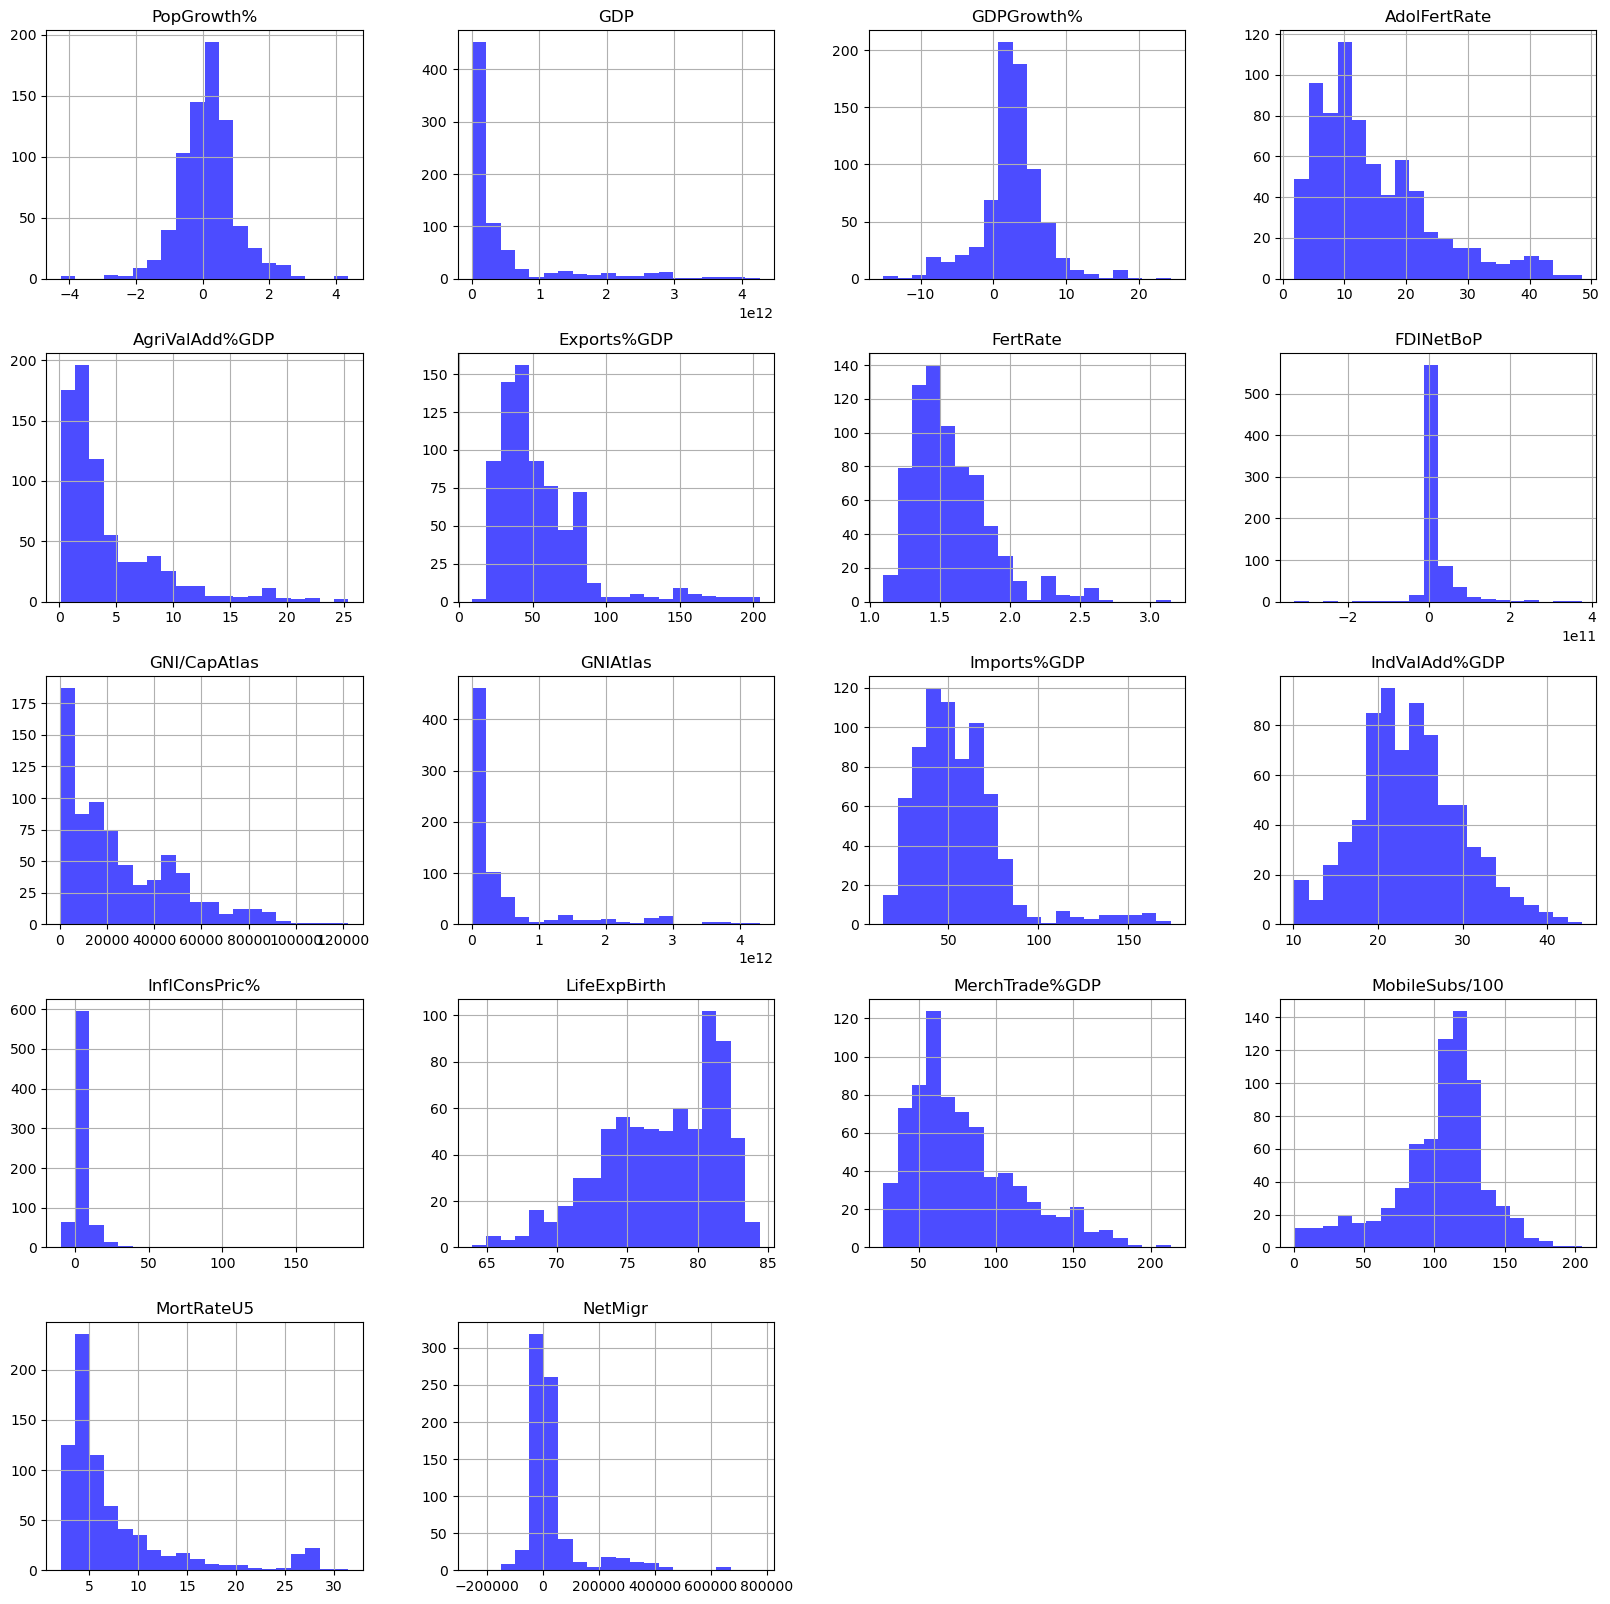

In [14]:
import matplotlib.pyplot as plt

train_set.hist(figsize=(20, 20), bins=20, color='blue', alpha=0.7)   
plt.savefig("Features_His.png")
plt.show()


PopGrowth%        1.000000
GNI/CapAtlas      0.575337
LifeExpBirth      0.533492
FertRate          0.375034
Exports%GDP       0.369476
NetMigr           0.246358
Imports%GDP       0.226293
MobileSubs/100    0.141927
FDINetBoP         0.119876
GDP               0.118878
GNIAtlas          0.116759
GDPGrowth%       -0.027223
MortRateU5       -0.121815
MerchTrade%GDP   -0.138129
InflConsPric%    -0.140101
IndValAdd%GDP    -0.182951
AgriValAdd%GDP   -0.302890
AdolFertRate     -0.427091
Name: PopGrowth%, dtype: float64


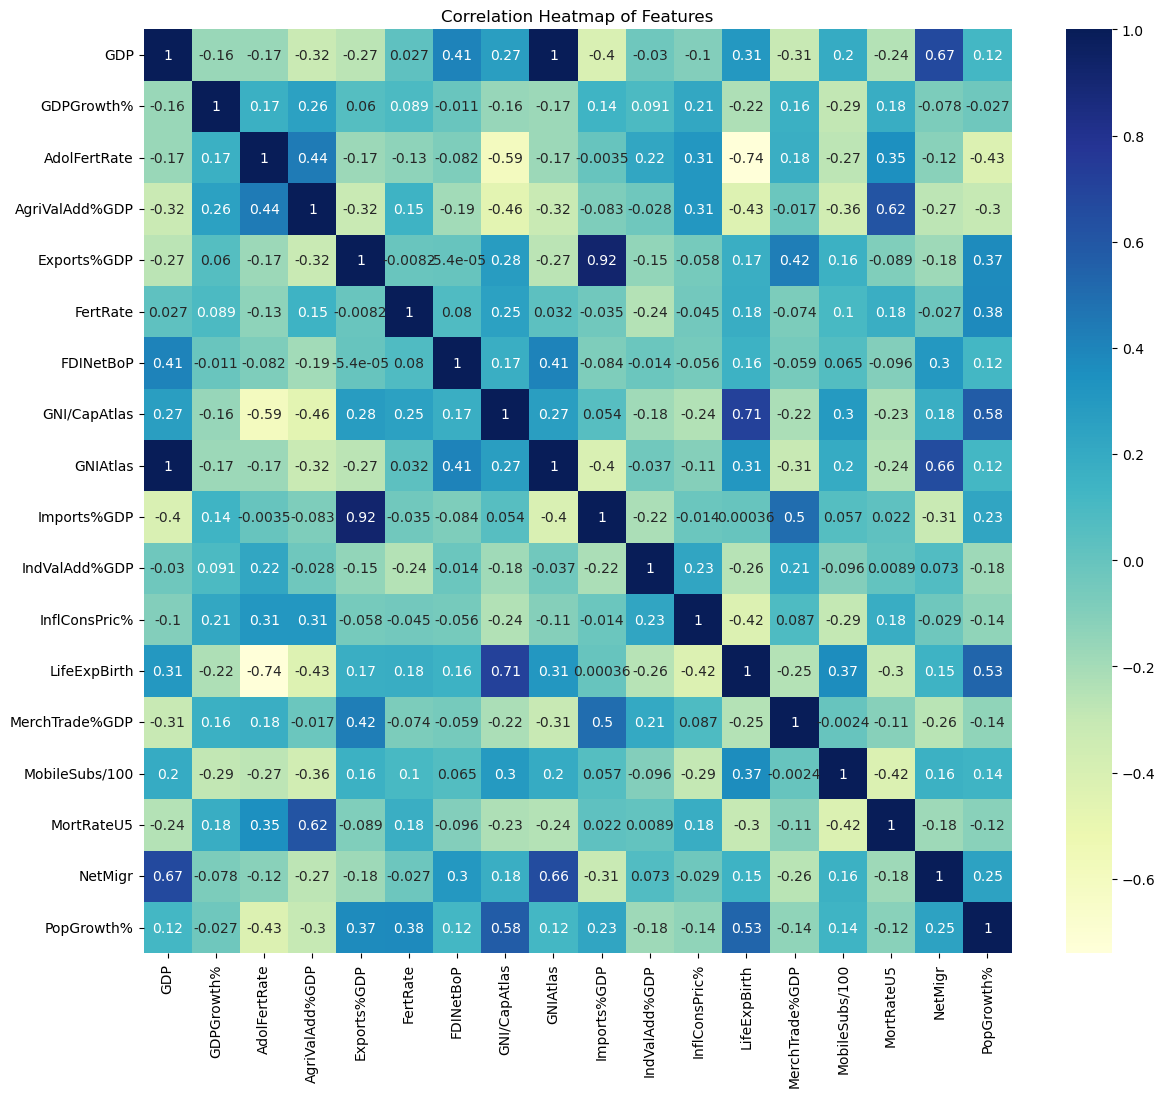

In [7]:
correlation_threshold = 0.2
train_corr = X_train.join(y_train).corr()

print(train_corr['PopGrowth%'].sort_values(ascending=False))

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(train_corr, cmap="YlGnBu", annot=True)
plt.title("Correlation Heatmap of Features")
plt.savefig("Featurs_Correlation.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
selected_features = train_corr.index[train_corr['PopGrowth%'].abs() >= correlation_threshold].tolist()
selected_features.remove('PopGrowth%')
print(selected_features)

['AdolFertRate', 'AgriValAdd%GDP', 'Exports%GDP', 'FertRate', 'GNI/CapAtlas', 'Imports%GDP', 'LifeExpBirth', 'NetMigr']


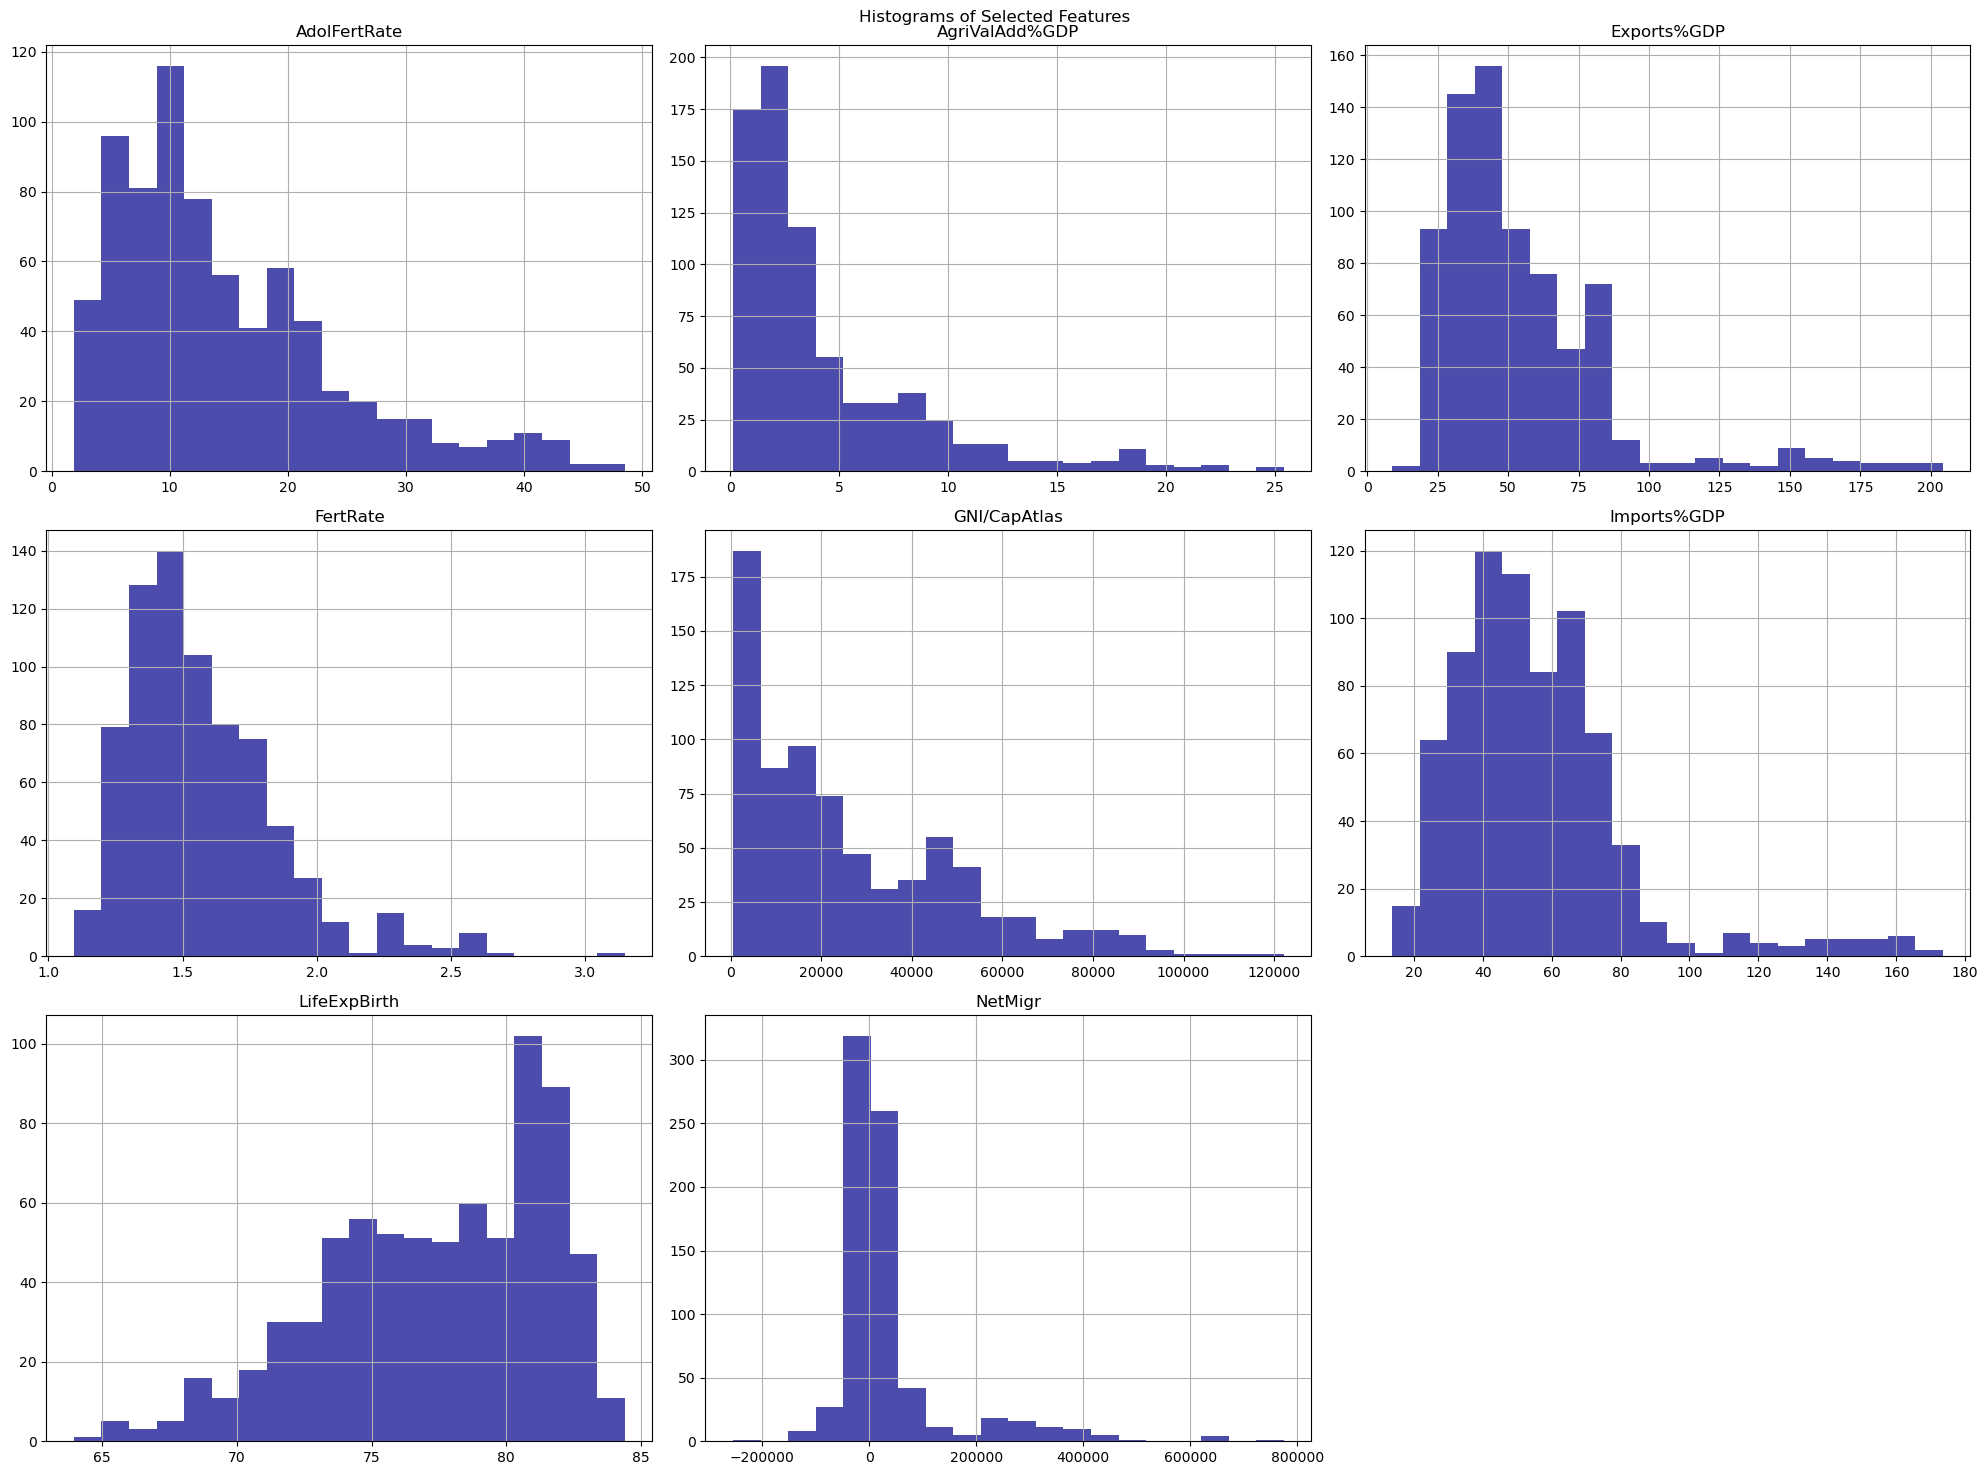

In [10]:
# Filter the DataFrame to include only the selected features
selected_data = train_set[selected_features]

# Plot histograms for the selected features
selected_data.hist(figsize=(20, 15), bins=20, color='darkblue', alpha=0.7)  # Adjust 'figsize' and 'bins' as needed
plt.suptitle("Histograms of Selected Features")  # Adds a title above all subplots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("Selected_Features_Histograms.png")
plt.show()


In [11]:
# Update X_train and X_test to keep only the selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


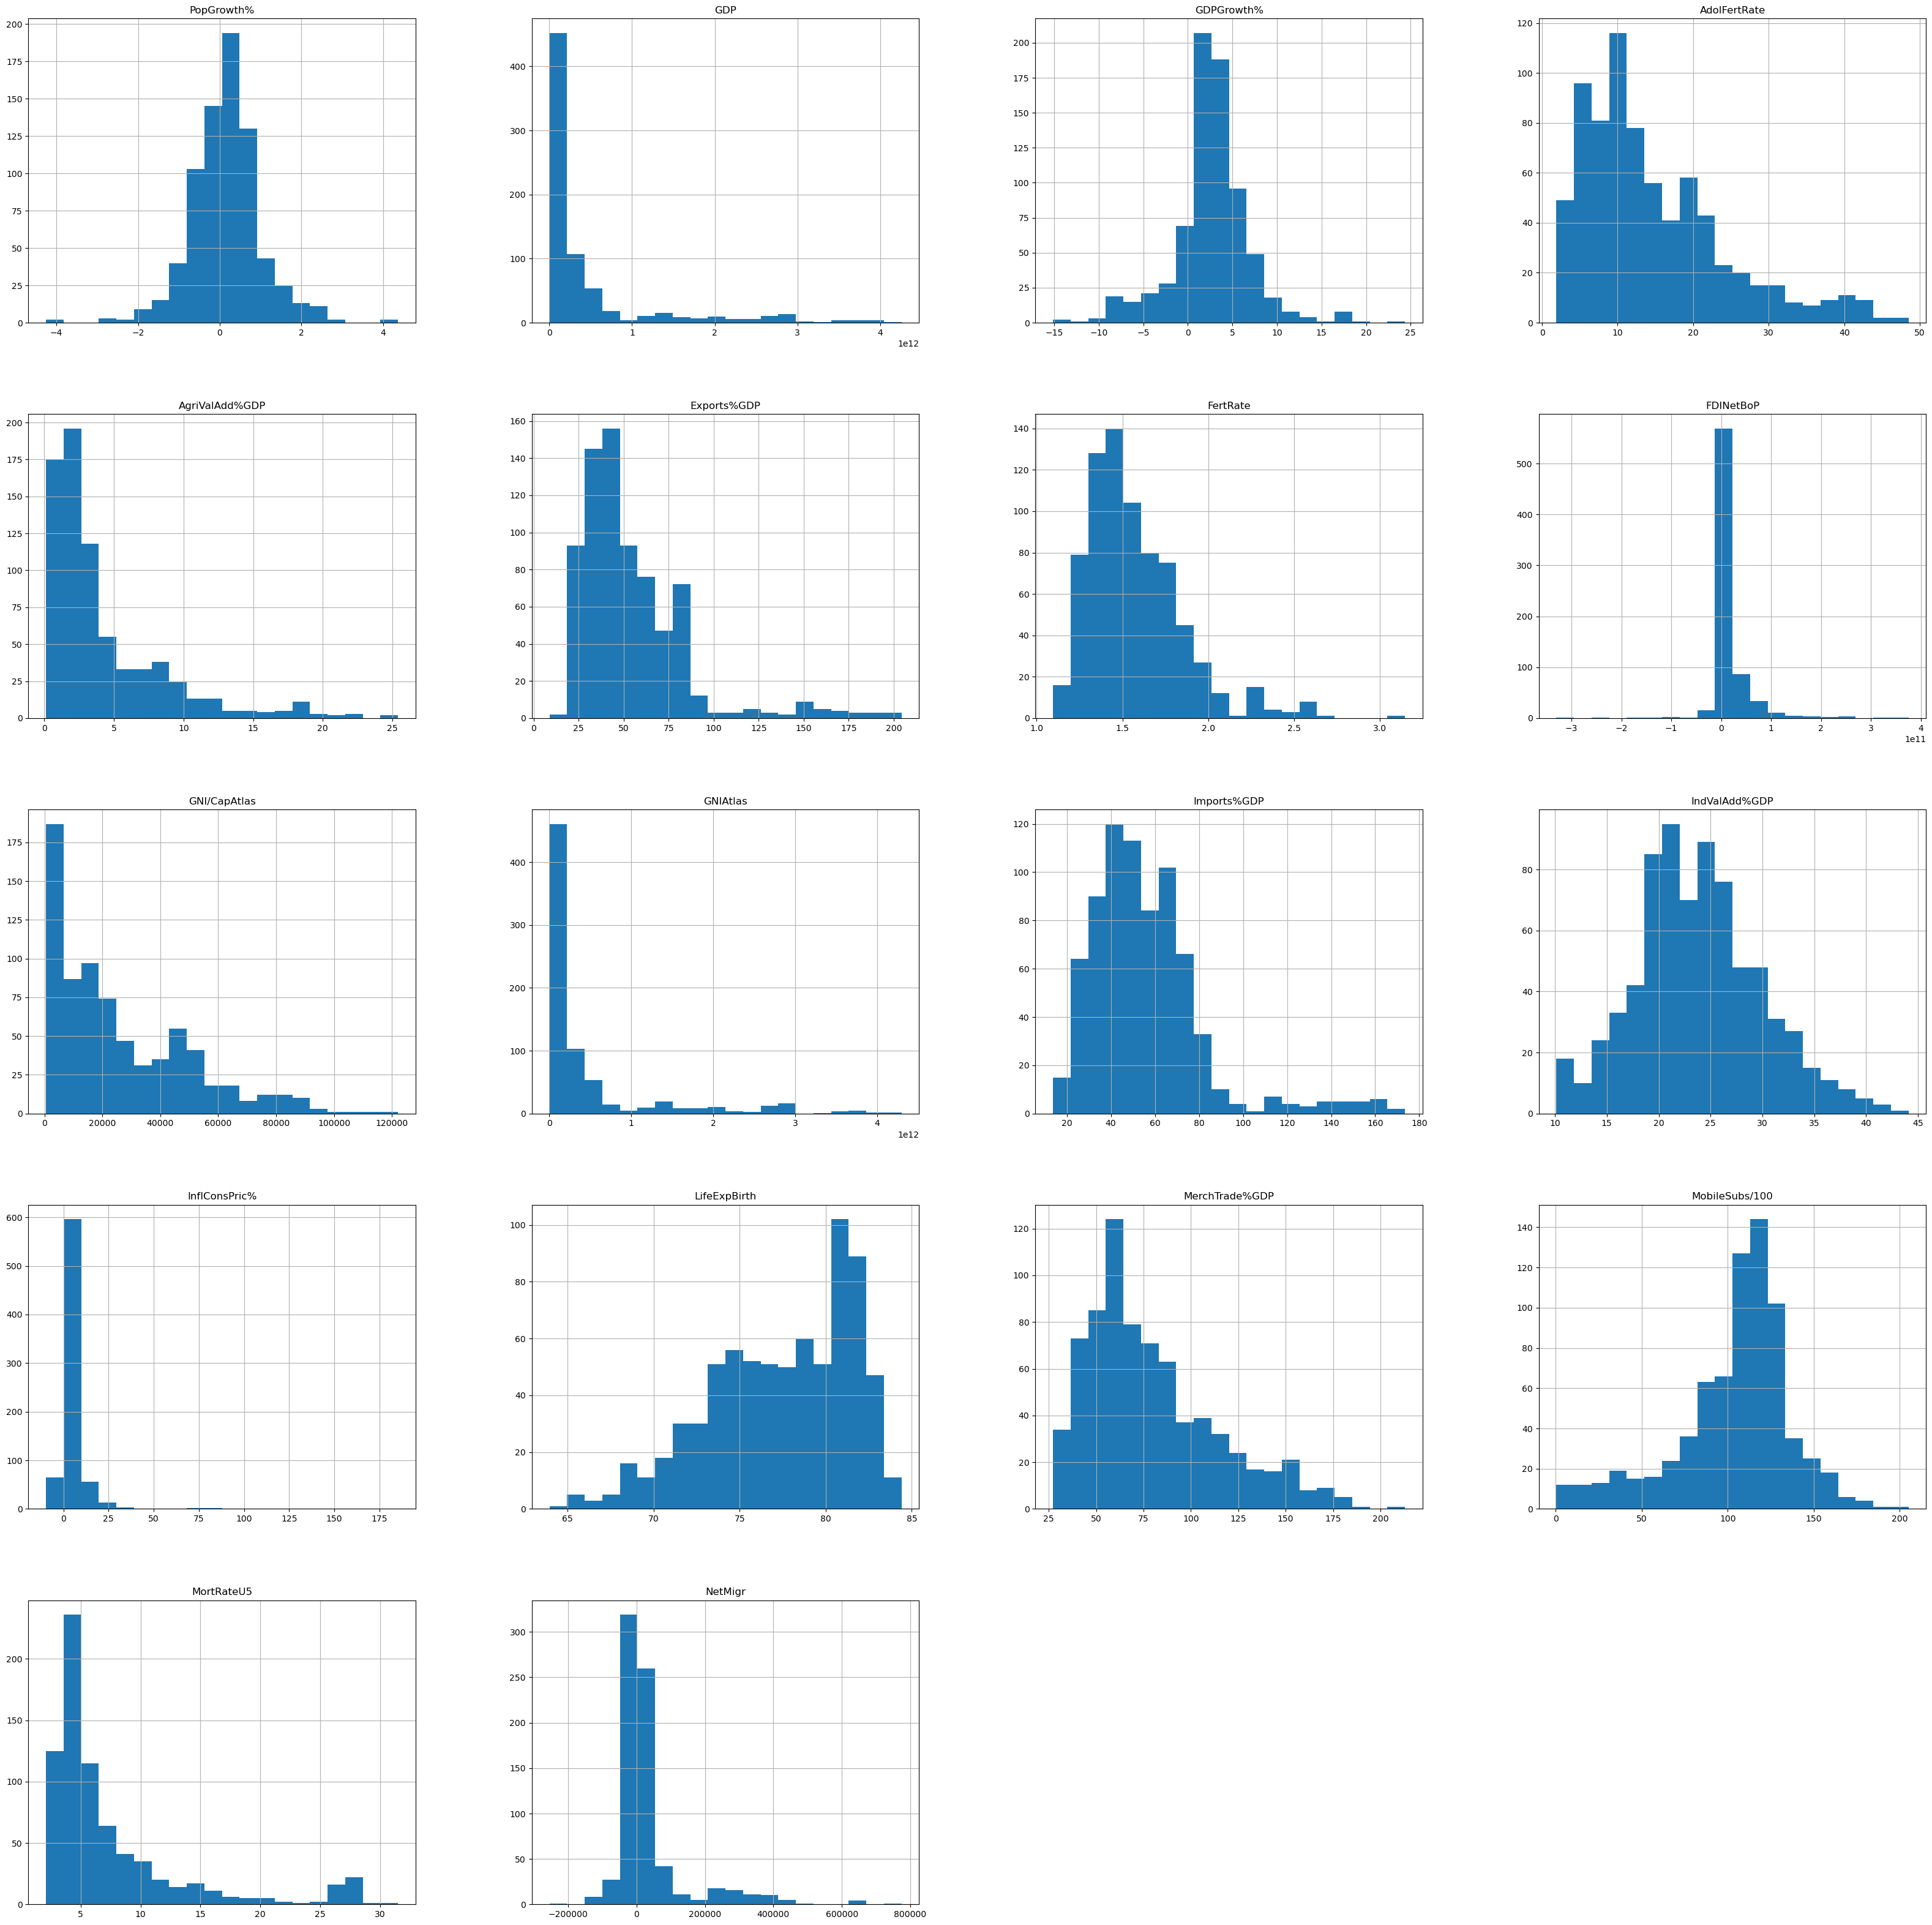

In [13]:
# Visualize the normalized features
train_set.hist(bins=20, figsize=(40, 40))
plt.savefig("Normalized_Features.png")
plt.show()

In [41]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(kernel='rbf', C=2),
    "XGBoost": XGBRegressor(),
    "Random Forest Regressor": RandomForestRegressor()
}

# Evaluate models
for name, model in models.items():
    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X_train, y_train, cv=kFold, scoring=scoring, error_score='raise')
    
    r2_scores = scores['test_r2']
    mse_scores = -scores['test_neg_mean_squared_error']
    mae_scores = -scores['test_neg_mean_absolute_error']
    
    print(f"{name}:")
    print("Cross-validation R^2 scores:", r2_scores)
    print("Mean R^2:", np.mean(r2_scores))
    print("Cross-validation MSE scores:", mse_scores)
    print("Mean MSE:", np.mean(mse_scores))
    print("Cross-validation MAE scores:", mae_scores)
    print("Mean MAE:", np.mean(mae_scores))
    print("\n")


Linear Regression:
Cross-validation R^2 scores: [0.65290191 0.63082707 0.48136483 0.37971322 0.41347967 0.52640663
 0.52316562 0.39247337 0.61080875 0.64672449]
Mean R^2: 0.5257865576486055
Cross-validation MSE scores: [0.18518809 0.21882209 0.42022079 0.39408533 0.54239107 0.4660939
 0.4216991  0.4747186  0.20717034 0.22379652]
Mean MSE: 0.3554185816618729
Cross-validation MAE scores: [0.33433959 0.33251062 0.39136494 0.44627961 0.42646418 0.43884315
 0.41388006 0.52646647 0.32777853 0.36627296]
Mean MAE: 0.40042001160608703


Support Vector Regression:
Cross-validation R^2 scores: [0.84349681 0.81739027 0.53800979 0.71432231 0.56314626 0.71881057
 0.6594115  0.58770867 0.80553166 0.81992601]
Mean R^2: 0.7067753858636396
Cross-validation MSE scores: [0.08349952 0.10823937 0.37432457 0.18149893 0.40398525 0.27673673
 0.30120702 0.32216261 0.10351741 0.11407508]
Mean MSE: 0.22692465016573302
Cross-validation MAE scores: [0.19303193 0.22910267 0.29513198 0.27760793 0.31095593 0.27476305


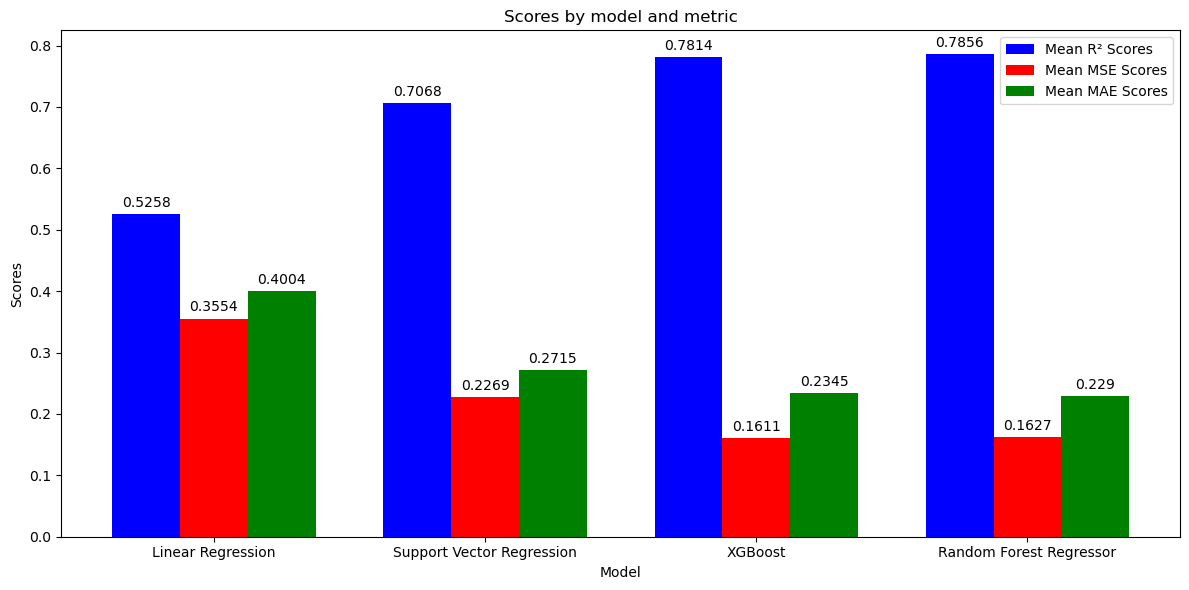

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Model data
models = ['Linear Regression', 'Support Vector Regression', 'XGBoost', 'Random Forest Regressor']
mean_r2_scores = [0.5258, 0.7068, 0.7814, 0.7856]
mean_mse_scores = [0.3554, 0.2269, 0.1611, 0.1627]
mean_mae_scores = [0.4004, 0.2715, 0.2345, 0.2290]

# X locations for the groups
ind = np.arange(len(models))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bar plots
rects1 = ax.bar(ind - width, mean_r2_scores, width, label='Mean R² Scores', color='blue')
rects2 = ax.bar(ind, mean_mse_scores, width, label='Mean MSE Scores', color='red')
rects3 = ax.bar(ind + width, mean_mae_scores, width, label='Mean MAE Scores', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(ind)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig("Comparing Models Evaluation before Tuning")
plt.show()


In [42]:
# Define hyperparameter grids
param_grid_lr = {}
param_grid_svr = {
    'C': [0.1, 1, 10, 100], 
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
param_grid_xgb = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 5, 7]
}
param_grid_rf = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20]
}

# Define models with hyperparameters grid
models = {
    "Linear Regression": (LinearRegression(), param_grid_lr),
    "Support Vector Regression": (SVR(), param_grid_svr),
    "XGBoost": (XGBRegressor(), param_grid_xgb),
    "Random Forest Regressor": (RandomForestRegressor(), param_grid_rf)
}

# Perform GridSearchCV
best_models = {}
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name} Best Parameters: {grid_search.best_params_}")

Linear Regression Best Parameters: {}
Support Vector Regression Best Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Random Forest Regressor Best Parameters: {'max_depth': 20, 'n_estimators': 300}


In [43]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np

# Dictionary to store the cross-validation results
cv_results = {}

# Evaluate the best models
for name, model in best_models.items():
    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X_train, y_train, cv=kFold, scoring=scoring, error_score='raise')
    
    r2_scores = scores['test_r2']
    mse_scores = -scores['test_neg_mean_squared_error']
    mae_scores = -scores['test_neg_mean_absolute_error']
    
    mean_r2 = np.mean(r2_scores)
    mean_mse = np.mean(mse_scores)
    mean_mae = np.mean(mae_scores)
    
    cv_results[name] = {
        'Mean R²': mean_r2,
        'Mean MSE': mean_mse,
        'Mean MAE': mean_mae,
        'R² Scores': r2_scores,
        'MSE Scores': mse_scores,
        'MAE Scores': mae_scores
    }
    
    print(f"{name}:")
    print("Cross-validation R² scores:", r2_scores)
    print("Mean R²:", mean_r2)
    print("Cross-validation MSE scores:", mse_scores)
    print("Mean MSE:", mean_mse)
    print("Cross-validation MAE scores:", mae_scores)
    print("Mean MAE:", mean_mae)
    print("\n")

# Rank models based on Mean R² score
ranked_models = sorted(cv_results.items(), key=lambda x: x[1]['Mean R²'], reverse=True)

print("Model Rankings based on Mean R² Score (Training Set):")
for idx, (model_name, metrics) in enumerate(ranked_models, start=1):
    print(f"{idx}. {model_name}: Mean R² = {metrics['Mean R²']:.4f}, Mean MSE = {metrics['Mean MSE']:.4f}, Mean MAE = {metrics['Mean MAE']:.4f}")


Linear Regression:
Cross-validation R² scores: [0.65290191 0.63082707 0.48136483 0.37971322 0.41347967 0.52640663
 0.52316562 0.39247337 0.61080875 0.64672449]
Mean R²: 0.5257865576486055
Cross-validation MSE scores: [0.18518809 0.21882209 0.42022079 0.39408533 0.54239107 0.4660939
 0.4216991  0.4747186  0.20717034 0.22379652]
Mean MSE: 0.3554185816618729
Cross-validation MAE scores: [0.33433959 0.33251062 0.39136494 0.44627961 0.42646418 0.43884315
 0.41388006 0.52646647 0.32777853 0.36627296]
Mean MAE: 0.40042001160608703


Support Vector Regression:
Cross-validation R² scores: [0.78252754 0.84111747 0.61679565 0.74789601 0.6399377  0.77240705
 0.66993054 0.64432751 0.83004355 0.88451351]
Mean R²: 0.7429496527869174
Cross-validation MSE scores: [0.11602861 0.0941754  0.31048884 0.16016863 0.33297154 0.22398896
 0.29190428 0.2779209  0.09046949 0.07315954]
Mean MSE: 0.19712761920857064
Cross-validation MAE scores: [0.19436455 0.2157815  0.26400395 0.25655413 0.27826529 0.26563487
 0.2

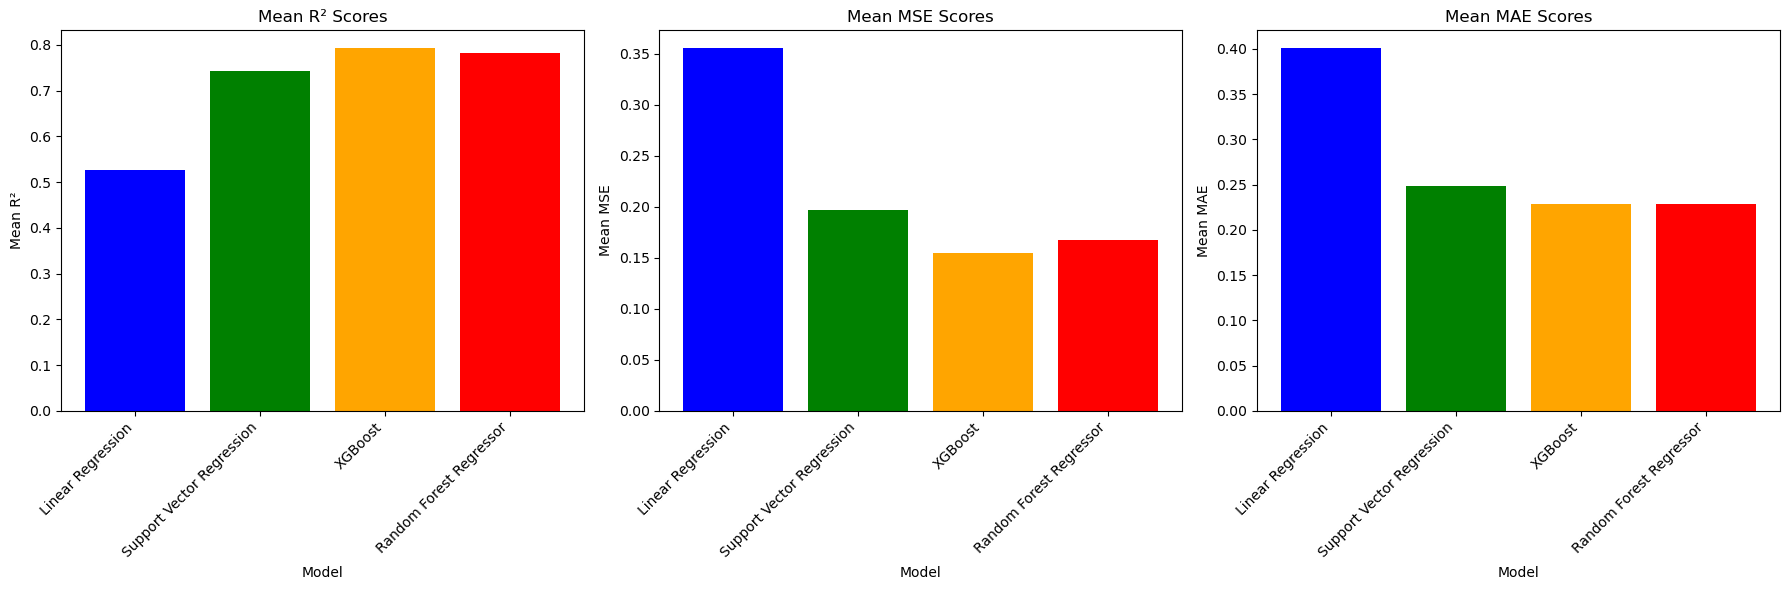

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Data for performance metrics based on the new information provided
model_names = ['Linear Regression', 'Support Vector Regression', 'XGBoost', 'Random Forest Regressor']
mean_r2_scores = [0.5258, 0.7429, 0.7921, 0.7813]
mean_mse_scores = [0.3554, 0.1971, 0.1552, 0.1679]
mean_mae_scores = [0.4004, 0.2482, 0.2283, 0.2282]

x = np.arange(len(model_names))  # the label locations

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot for R² scores
ax[0].bar(x, mean_r2_scores, color=['blue', 'green', 'orange', 'red'])
ax[0].set_title('Mean R² Scores')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Mean R²')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names, rotation=45, ha='right')

# Plot for MSE scores
ax[1].bar(x, mean_mse_scores, color=['blue', 'green', 'orange', 'red'])
ax[1].set_title('Mean MSE Scores')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Mean MSE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names, rotation=45, ha='right')

# Plot for MAE scores
ax[2].bar(x, mean_mae_scores, color=['blue', 'green', 'orange', 'red'])
ax[2].set_title('Mean MAE Scores')
ax[2].set_xlabel('Model')
ax[2].set_ylabel('Mean MAE')
ax[2].set_xticks(x)
ax[2].set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("Model_Performance_Comparison_trainset.png")
plt.show()

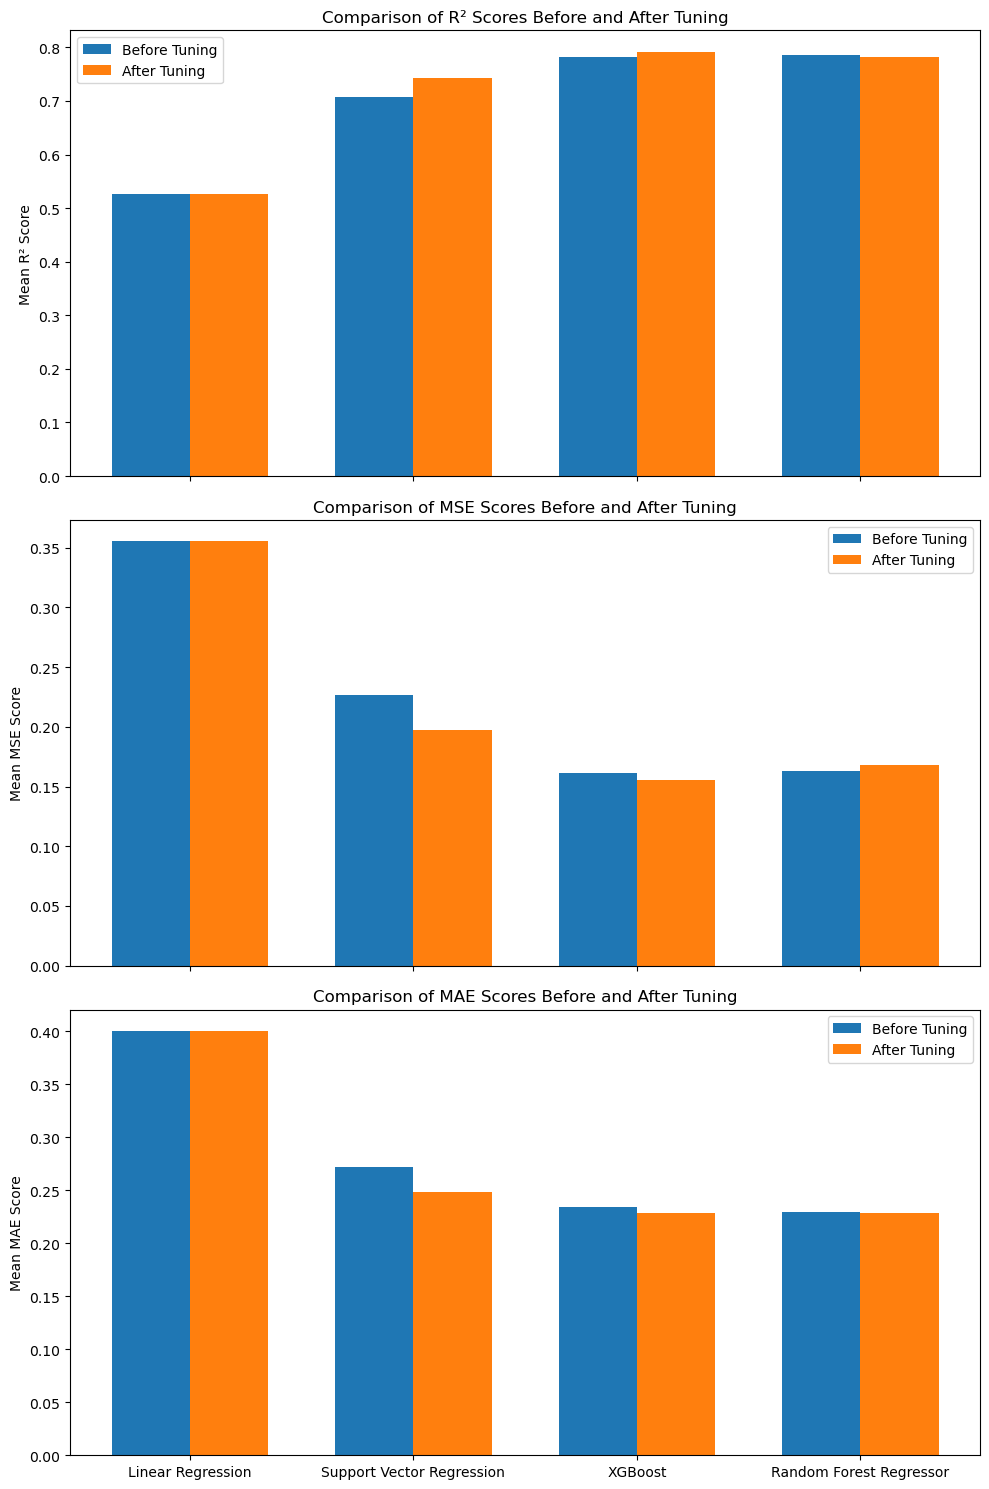

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their scores
models = ['Linear Regression', 'Support Vector Regression', 'XGBoost', 'Random Forest Regressor']
scores_before_tuning = {
    'R2': [0.5258, 0.7068, 0.7814, 0.7856],
    'MSE': [0.3554, 0.2269, 0.1611, 0.1627],
    'MAE': [0.4004, 0.2715, 0.2345, 0.2290]
}
scores_after_tuning = {
    'R2': [0.5258, 0.7429, 0.7921, 0.7813],
    'MSE': [0.3554, 0.1971, 0.1552, 0.1679],
    'MAE': [0.4004, 0.2482, 0.2283, 0.2282]
}

# Number of models
n_models = len(models)

# X locations for the groups
ind = np.arange(n_models)
width = 0.35  # width of the bars

# Create the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# R2 Scores plot
ax[0].bar(ind - width/2, scores_before_tuning['R2'], width, label='Before Tuning')
ax[0].bar(ind + width/2, scores_after_tuning['R2'], width, label='After Tuning')
ax[0].set_ylabel('Mean R² Score')
ax[0].set_title('Comparison of R² Scores Before and After Tuning')
ax[0].set_xticks(ind)
ax[0].set_xticklabels(models)
ax[0].legend()

# MSE Scores plot
ax[1].bar(ind - width/2, scores_before_tuning['MSE'], width, label='Before Tuning')
ax[1].bar(ind + width/2, scores_after_tuning['MSE'], width, label='After Tuning')
ax[1].set_ylabel('Mean MSE Score')
ax[1].set_title('Comparison of MSE Scores Before and After Tuning')
ax[1].legend()

# MAE Scores plot
ax[2].bar(ind - width/2, scores_before_tuning['MAE'], width, label='Before Tuning')
ax[2].bar(ind + width/2, scores_after_tuning['MAE'], width, label='After Tuning')
ax[2].set_ylabel('Mean MAE Score')
ax[2].set_title('Comparison of MAE Scores Before and After Tuning')
ax[2].legend()

# Show the plot
plt.tight_layout()
plt.savefig("Model_Comparison_before_after_tuning")
plt.show()


In [48]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Dictionary to store the test set performance results
test_results = {}

# Evaluate each model on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    test_results[name] = {
        'R² Score': r2,
        'MSE': mse,
        'MAE': mae
    }
    
    print(f"Test set performance for {name}:")
    print(f"R² Score: {r2}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print("\n")

# Rank models based on R² score on the test set
ranked_test_models = sorted(test_results.items(), key=lambda x: x[1]['R² Score'], reverse=True)

print("Model Rankings based on R² Score (Test Set):")
for idx, (model_name, metrics) in enumerate(ranked_test_models, start=1):
    print(f"{idx}. {model_name}: R² Score = {metrics['R² Score']:.4f}, MSE = {metrics['MSE']:.4f}, MAE = {metrics['MAE']:.4f}")


Test set performance for Linear Regression:
R² Score: 0.4274174885984575
MSE: 0.5662393813179499
MAE: 0.48160551834997983


Test set performance for Support Vector Regression:
R² Score: 0.7236201388483521
MSE: 0.2733180955949617
MAE: 0.2892075575913593


Test set performance for XGBoost:
R² Score: 0.7312316892834702
MSE: 0.2657908667267556
MAE: 0.2773950246501883


Test set performance for Random Forest Regressor:
R² Score: 0.7878599043916027
MSE: 0.20978998502067428
MAE: 0.2574823668492679


Model Rankings based on R² Score (Test Set):
1. Random Forest Regressor: R² Score = 0.7879, MSE = 0.2098, MAE = 0.2575
2. XGBoost: R² Score = 0.7312, MSE = 0.2658, MAE = 0.2774
3. Support Vector Regression: R² Score = 0.7236, MSE = 0.2733, MAE = 0.2892
4. Linear Regression: R² Score = 0.4274, MSE = 0.5662, MAE = 0.4816


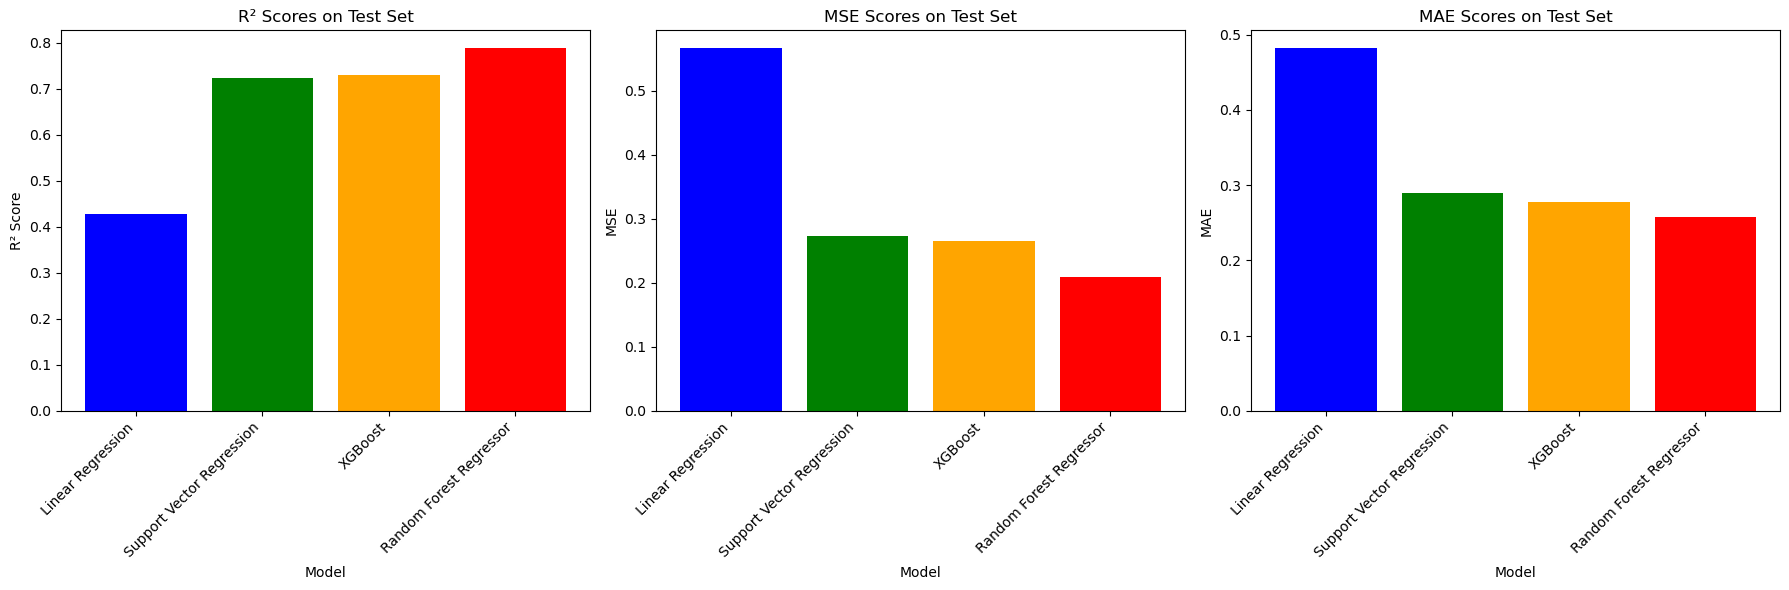

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data for performance metrics based on the new rankings provided
model_names = ['Linear Regression', 'Support Vector Regression', 'XGBoost', 'Random Forest Regressor']
test_r2_scores = [0.4274, 0.7236, 0.7312, 0.7879]  # Updated to reflect new rankings
test_mse_scores = [0.5662, 0.2733, 0.2658, 0.2098]  # Updated to reflect new rankings
test_mae_scores = [0.4816, 0.2892, 0.2774, 0.2575]  # Updated to reflect new rankings

x = np.arange(len(model_names))  # the label locations

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot for R² scores
ax[0].bar(x, test_r2_scores, color=['blue', 'green', 'orange', 'red'])
ax[0].set_title('R² Scores on Test Set')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('R² Score')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names, rotation=45, ha='right')

# Plot for MSE scores
ax[1].bar(x, test_mse_scores, color=['blue', 'green', 'orange', 'red'])
ax[1].set_title('MSE Scores on Test Set')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('MSE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names, rotation=45, ha='right')

# Plot for MAE scores
ax[2].bar(x, test_mae_scores, color=['blue', 'green', 'orange', 'red'])
ax[2].set_title('MAE Scores on Test Set')
ax[2].set_xlabel('Model')
ax[2].set_ylabel('MAE')
ax[2].set_xticks(x)
ax[2].set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("Model_Performance_Comparison_testset.png")
plt.show()


Random Forest Regressor Permutation Feature Importance:
          Feature  Importance
7         NetMigr    0.555163
1  AgriValAdd%GDP    0.287516
0    AdolFertRate    0.204891
6    LifeExpBirth    0.125827
4    GNI/CapAtlas    0.119140
3        FertRate    0.091930
2     Exports%GDP    0.081427
5     Imports%GDP    0.028346


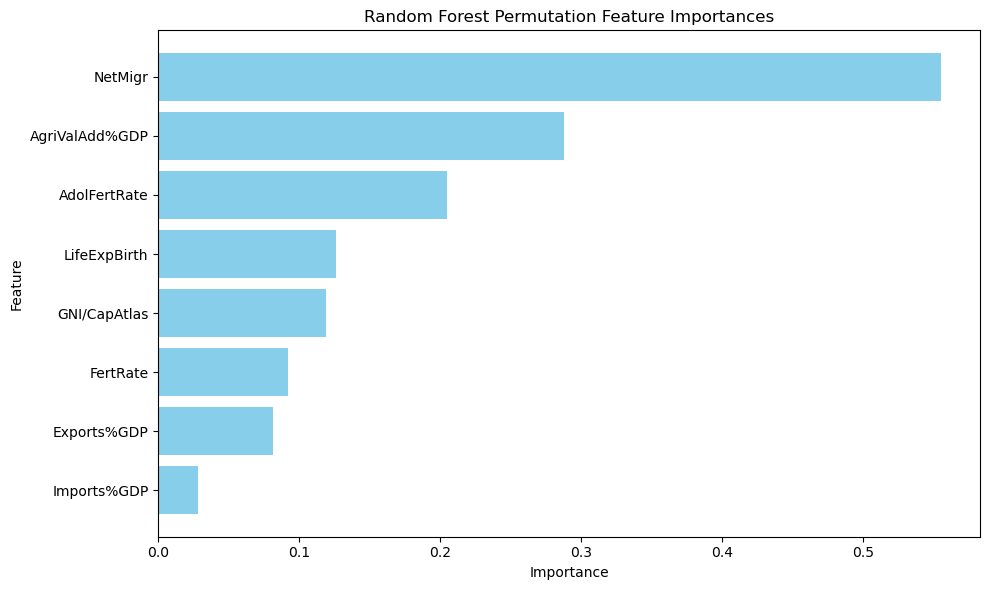

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor 
from sklearn.inspection import permutation_importance

# Fit Random Forest model as the best model performance
rf_model = RandomForestRegressor(n_estimators=300,max_depth=20, random_state=42)  # Adjust hyperparameters as needed
rf_model.fit(X_train, y_train)

# Get permutation feature importances based on the test set
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Random Forest Regressor Permutation Feature Importance:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Permutation Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("RF_Feature_Importances.png")
plt.show()


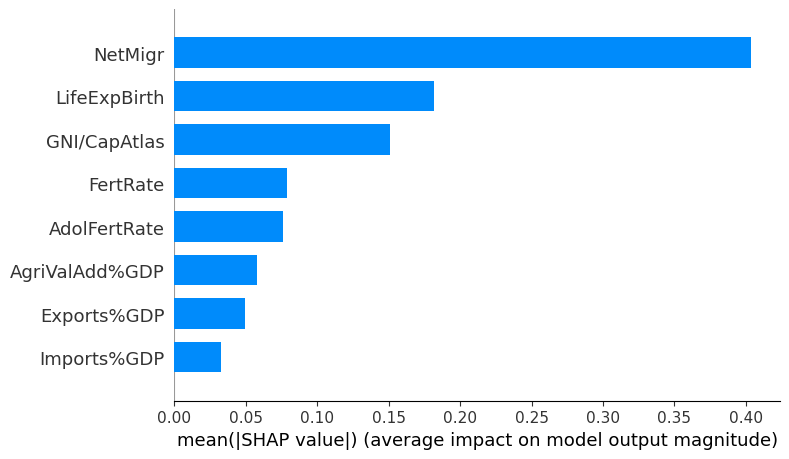

In [29]:
# SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_train)
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

XGBoost Permutation Feature Importance:
          Feature  Importance
7         NetMigr    0.530260
3        FertRate    0.184146
4    GNI/CapAtlas    0.164173
0    AdolFertRate    0.144744
1  AgriValAdd%GDP    0.088525
6    LifeExpBirth    0.084663
2     Exports%GDP    0.068166
5     Imports%GDP    0.023649


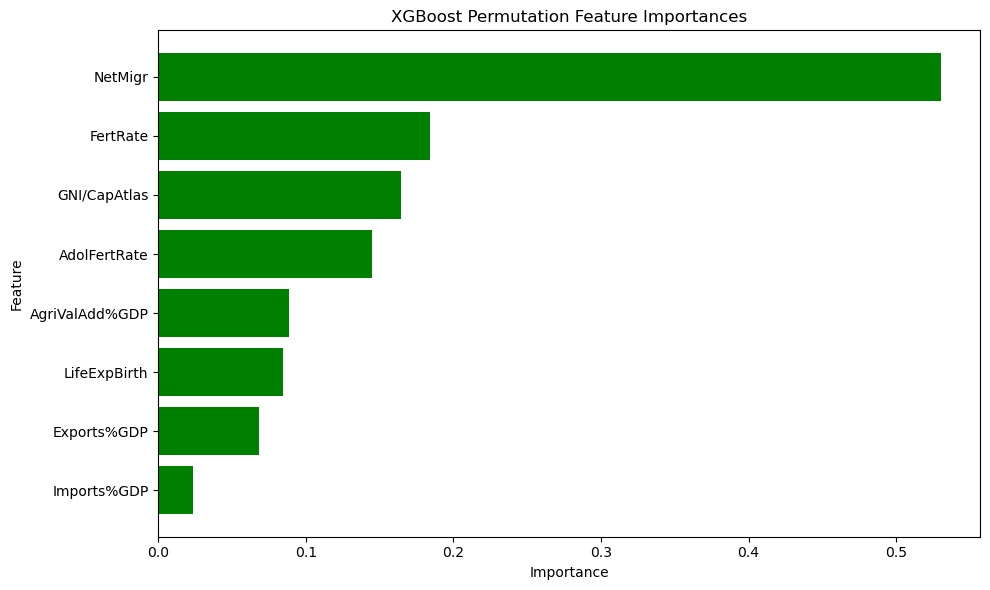

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

# XGBoost Model
xgb_model = XGBRegressor(n_estimators=300,max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
result_xgb = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_xgb = pd.DataFrame({'Feature': X_test.columns, 'Importance': result_xgb.importances_mean})
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)

# Print feature importances
print("XGBoost Permutation Feature Importance:")
print(importance_xgb)

# Plotting feature importances for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(importance_xgb['Feature'], importance_xgb['Importance'], color='green')
plt.gca().invert_yaxis()
plt.title('XGBoost Permutation Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("XGB_Feature_Importances.png")
plt.show()


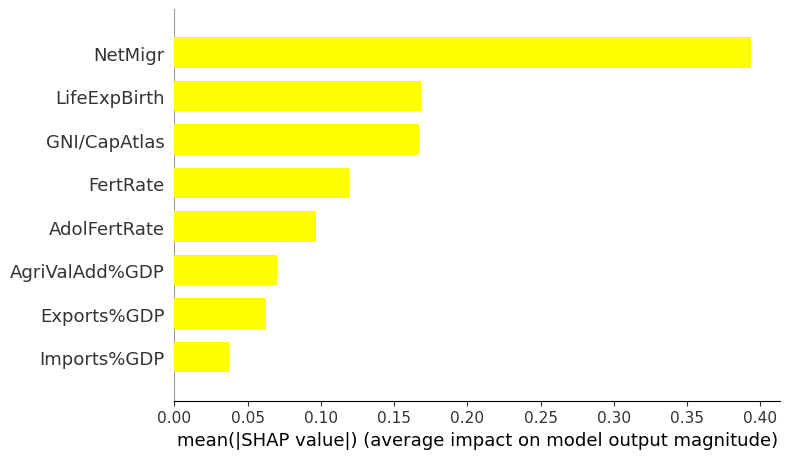

In [36]:
# SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_train)
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar", color= "yellow")

SVR Permutation Feature Importance:
          Feature  Importance
3        FertRate    0.498711
2     Exports%GDP    0.275080
4    GNI/CapAtlas    0.263498
6    LifeExpBirth    0.260592
7         NetMigr    0.250032
0    AdolFertRate    0.231015
5     Imports%GDP    0.175674
1  AgriValAdd%GDP    0.165842


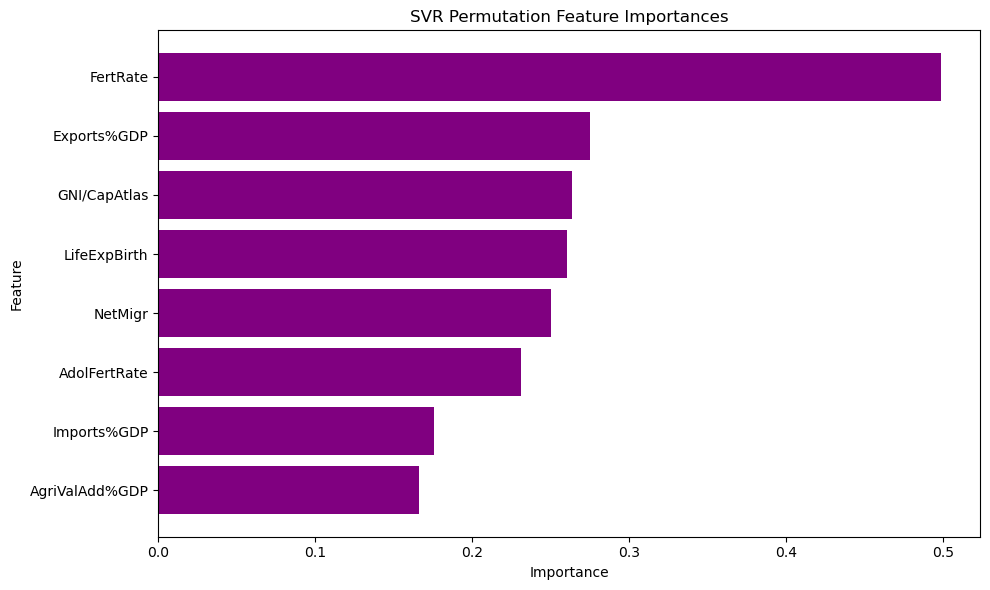

In [34]:
# SVR Model
svr_model = SVR(C=10, epsilon=0.1, kernel='rbf')  # Adjust kernel and other hyperparameters as needed
svr_model.fit(X_train, y_train)
result_svr = permutation_importance(svr_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_svr = pd.DataFrame({'Feature': X_test.columns, 'Importance': result_svr.importances_mean})
importance_svr = importance_svr.sort_values(by='Importance', ascending=False)

# Print feature importances
print("SVR Permutation Feature Importance:")
print(importance_svr)

# Plotting feature importances for SVR
plt.figure(figsize=(10, 6))
plt.barh(importance_svr['Feature'], importance_svr['Importance'], color='purple')
plt.gca().invert_yaxis()
plt.title('SVR Permutation Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("SVR_Feature_Importances.png")
plt.show()


In [35]:
from sklearn.linear_model import LinearRegression

# Fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Coefficients as feature importances
importance_lr = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_model.coef_})
importance_lr = importance_lr.sort_values(by='Coefficient', key=abs, ascending=False)

# Print feature importances
print("Linear Regression Coefficients:")
print(importance_lr)


Linear Regression Coefficients:
          Feature  Coefficient
3        FertRate     0.244378
7         NetMigr     0.217916
6    LifeExpBirth     0.217822
2     Exports%GDP     0.212562
4    GNI/CapAtlas     0.175053
5     Imports%GDP     0.067826
1  AgriValAdd%GDP     0.017089
0    AdolFertRate    -0.015560
